In [ ]:
# Import necessary modules

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from imutils import paths
import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import cv2


In [ ]:
import zipfile
import os
from imutils import paths

# Extract the zip file
with zipfile.ZipFile("/content/brain-tumor-detection.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/brain-tumor-detection") # Extract to a directory named "brain-tumor-detection"

# Load the images directories, update path to point to extracted directory
path = "/content/brain-tumor-detection" # Path is now the extracted directory
print(os.listdir(path))

image_paths = list(paths.list_images(path))
print(len(image_paths))

['brain_tumor_dataset', 'yes', 'no']
506


In [ ]:
#
images = []
labels = []

for image_path in image_paths:
    label = image_path.split(os.path.sep)[-2]
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))

    images.append(image)
    labels.append(label)


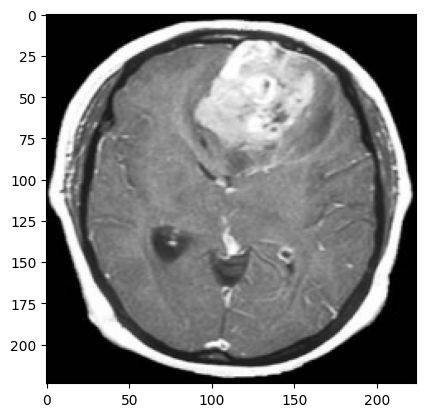

In [ ]:
# Plot an image
def plot_image(image):
    plt.imshow(image)

plot_image(images[0])



In [ ]:

# Convert into numpy arrays
images = np.array(images) / 255.0
labels = np.array(labels)



In [ ]:
# Perform One-hot encoding
label_binarizer = LabelBinarizer()
labels = label_binarizer.fit_transform(labels)
labels = to_categorical(labels)

print(labels[0])


[0. 1.]


In [ ]:
#Split the dataset
(train_X, test_X, train_Y, test_Y) = train_test_split(images, labels, test_size= 0.10, random_state= 42, stratify= labels)


In [ ]:
# Build the Image Data Generator
train_generator = ImageDataGenerator(fill_mode= 'nearest', rotation_range= 15)


In [ ]:
# Build the model
base_model = VGG16(weights= 'imagenet', input_tensor= Input(shape = (224, 224, 3)), include_top= False)
base_input = base_model.input
base_output = base_model.output
base_output = AveragePooling2D(pool_size=(4, 4))(base_output)
base_output = Flatten(name="flatten")(base_output)
base_output = Dense(64, activation="relu")(base_output)
base_output = Dropout(0.5)(base_output)
base_output = Dense(2, activation="softmax")(base_output)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
# Freeze the layers
for layer in base_model.layers:
    layer.trainable = False


In [ ]:

# Compile the model
model = Model(inputs = base_input, outputs = base_output)
model.compile(optimizer= Adam(learning_rate= 1e-3), metrics= ['accuracy'], loss= 'binary_crossentropy')


In [ ]:
# Let's see the architecture summary of our model
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 14,747,650 (56.26 MB)

 Trainable params: 32,962 (128.76 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:

batch_size = 8
train_steps = len(train_X) // batch_size
validation_steps = len(test_X) // batch_size
epochs = 10


In [ ]:
# Fit the model
history = model.fit(train_generator.flow(train_X, train_Y, batch_size=batch_size),
                    steps_per_epoch=train_steps,
                    validation_data=(test_X, test_Y),
                    validation_steps=validation_steps,
                    epochs=epochs)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


56/56 ━━━━━━━━━━━━━━━━━━━━ 328s 6s/step - accuracy: 0.5392 - loss: 0.7283 - val_accuracy: 0.6078 - val_loss: 0.6698
Epoch 2/10
 1/56 ━━━━━━━━━━━━━━━━━━━━ 4:50 5s/step - accuracy: 0.6250 - loss: 0.6589

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


56/56 ━━━━━━━━━━━━━━━━━━━━ 39s 613ms/step - accuracy: 0.6250 - loss: 0.6589 - val_accuracy: 0.6078 - val_loss: 0.6700
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 320s 5s/step - accuracy: 0.6017 - loss: 0.6883 - val_accuracy: 0.6078 - val_loss: 0.6725
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 45s 745ms/step - accuracy: 0.5714 - loss: 0.7323 - val_accuracy: 0.6078 - val_loss: 0.6730
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 342s 6s/step - accuracy: 0.5978 - loss: 0.6719 - val_accuracy: 0.6078 - val_loss: 0.6698
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 47s 745ms/step - accuracy: 0.7500 - loss: 0.5744 - val_accuracy: 0.6078 - val_loss: 0.6698
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 336s 6s/step - accuracy: 0.5918 - loss: 0.6822 - val_accuracy: 0.6078 - val_loss: 0.6699
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 35s 549ms/step - accuracy: 0.3750 - loss: 0.7661 - val_accuracy: 0.6078 - val_loss: 0.6698
Epoch 9/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 308s 6s/step - accuracy: 0.6364 - loss: 0.6779 - val_accuracy: 0.6078 - val_

In [ ]:
# Evaluate the model
predictions = model.predict(test_X, batch_size= batch_size)
predictions = np.argmax(predictions, axis= 1)
actuals = np.argmax(test_Y, axis= 1)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(8, 224, 224, 3))
  warnings.warn(msg)


7/7 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step


In [ ]:
# Print Classification report and Confusion matrix
print(classification_report(actuals, predictions, target_names= label_binarizer.classes_))

cm = confusion_matrix(actuals, predictions)
print(cm)


              precision    recall  f1-score   support

          no       0.00      0.00      0.00        20
         yes       0.61      1.00      0.76        31

    accuracy                           0.61        51
   macro avg       0.30      0.50      0.38        51
weighted avg       0.37      0.61      0.46        51

[[ 0 20]
 [ 0 31]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Final accuracy of our model
total = sum(sum(cm))
accuracy = (cm[0, 0] + cm[1, 1]) / total
print("Accuracy: {:.4f}".format(accuracy))


Accuracy: 0.6078


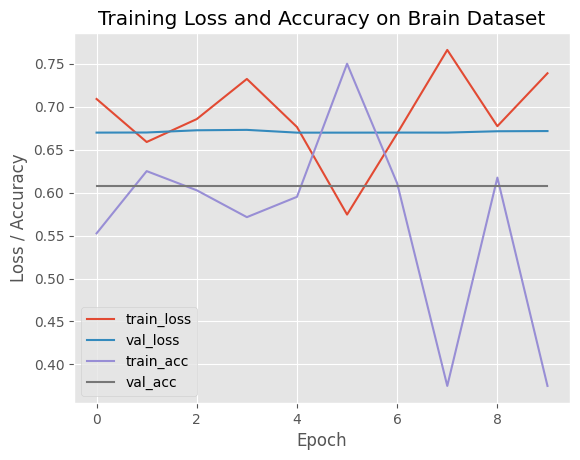

In [ ]:


# Plot the losses and accuracies
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label= "train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label= "val_loss")

plt.plot(np.arange(0, N), history.history["accuracy"], label= "train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label= "val_acc")

plt.title("Training Loss and Accuracy on Brain Dataset")
plt.xlabel("Epoch")
plt.ylabel("Loss / Accuracy")
plt.legend(loc= "lower left")
plt.savefig("plot.jpg")
